In [96]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

from matplotlib import pyplot

import random

import time

from matplotlib.colors import Normalize

import matplotlib.pyplot as plt

import keras

from multiprocessing import Pool


In [97]:

BOARD_SIZE = 10 # 15?
BATCH_SIZE = 500 # 500?
ONE_LOOP_DATA = 200 # 100? 1000?
EPOCHS = 25 # 50?


In [98]:
!ls -lha output

total 0
drwxr-xr-x   2 osku  staff    64B Jan 14 18:36 .
drwxr-xr-x  13 osku  staff   416B Jan 15 07:26 ..


In [99]:
models = []
model_index = 0
while True:
    try:
        model = keras.models.load_model('my-model-{}.h5'.format(model_index))
        models.append(model)
        print('model loaded')
    except OSError:
        break
    model_index += 1

In [163]:
models = [keras.models.load_model('base-model.h5')]

In [164]:
models

In [125]:

def get_play_pos(board_moves, depth=0):
    board_sum = random.random() * np.sum(board_moves)
    for x in range(BOARD_SIZE):
        line_sum = np.sum(board_moves[x])
        
        #print('hmm board_sum: {}, line_sum: {}'.format(board_sum, line_sum))
        
        if board_sum > line_sum:
            #print('removing line')
            #print('asdf', x, board_sum, line_sum, board_moves[x])
            #print('wtf1', board_sum, line_sum, type(board_sum), type(line_sum))
            board_sum -= line_sum
            #print('wtf2', board_sum, line_sum, type(board_sum), type(line_sum))
            continue
        else:
            pass
            #print('wwww', x, board_sum, board_moves[x])
        
        for y in range(BOARD_SIZE):
            #print('removing cell')
            board_sum -= board_moves[x][y][0]
            if board_sum <= 0:
                return x, y
    
    # raise Exception('WUTWUT')
    
    if depth < 4:
        print('Error happened')
        return get_play_pos(board_moves, depth=depth+1)
    
    print('WHY WHYW HY WHY')
    return 0, 0
    
    raise Exception('This should not happen {}'.format(board_sum))

    
def get_best_play_pos(board_moves):
    best_x, best_y, best_score = 0, 0, 0
    for x in range(BOARD_SIZE):
        for y in range(BOARD_SIZE):
            # print(x, y, best_x, best_y, best_score, board_moves[x][y])
            if board_moves[x][y] > best_score:
                best_x, best_y, best_score = x, y, board_moves[x][y]
    return best_x, best_y

   
'''
def define_winning(board):
    for x in range(BOARD_SIZE - 5):
        for y in range(BOARD_SIZE - 5):
            hor = True
            ver = True
            dia1 = True
            dia2 = True
            
            for i in range(1, 5):
                if board[x][y][0] != board[x][y + i][0]:
                    ver = False
                if board[x][y][0] != board[x + i][y + i][0]:
                    dia1 = False
                if board[x][y][0] != board[x + i][y][0]:
                    hor = False
                if board[BOARD_SIZE - x - 1][y][0] != board[BOARD_SIZE - x - i - 1][y + i][0]:
                    dia2 = False
            
            if (hor or ver or dia1) and board[x][y][0] != 0:
                #print('WINNER', x, y, hor, ver, dia1)
                #vis_board(board)
                return board[x][y][0]
            
            if dia2 and board[BOARD_SIZE - x - 1][y][0] != 0:
                return board[BOARD_SIZE - x - 1][y][0]
    return 0
'''


def define_winning(board, x, y):
    value = board[x][y][0]
    
    # X direction
    count = 1
    i = 1
    while x - i >= 0 and board[x - i][y][0] == value:
        count += 1
        i += 1
    i = 1
    while x + i < BOARD_SIZE and board[x + i][y][0] == value:
        count += 1
        i += 1
    if count >= 5:
        return True
    
    # Y direction
    count = 1
    i = 1
    while y - i >= 0 and board[x][y - i][0] == value:
        count += 1
        i += 1
    i = 1
    while y + i < BOARD_SIZE and board[x][y + i][0] == value:
        count += 1
        i += 1
    if count >= 5:
        return True
    
    # Diagonal 1
    count = 1
    i = 1
    while x - i >= 0 and y - i >= 0 and board[x - i][y - i][0] == value:
        count += 1
        i += 1
    i = 1
    while x + i < BOARD_SIZE and y + i < BOARD_SIZE and board[x + i][y + i][0] == value:
        count += 1
        i += 1
    if count >= 5:
        return True
    
    # Diagonal 2
    count = 1
    i = 1
    while x - i >= 0 and y + i < BOARD_SIZE and board[x - i][y + i][0] == value:
        count += 1
        i += 1
    i = 1
    while x + i < BOARD_SIZE and y - i >= 0 and board[x + i][y - i][0] == value:
        count += 1
        i += 1
    if count >= 5:
        return True
    
    return False


def do_monte_carlo(board, monte_carlo_player, model):
    # Do a batch for each location on the board (non played)
    
    monte_carlo_result = np.zeros((BOARD_SIZE, BOARD_SIZE))
    
    # Do monte carlo for each point in the board
    for x in range(BOARD_SIZE):
        for y in range(BOARD_SIZE):    
            # Don't do monte carlo for already played positions
            if board[x][y] != 0:
                continue
                
            # Don't do monte carlo if no plays around
            # if np.count_nonzero(board[x-2:x+1][y-2:y+1] != 0) == 0:
            if np.count_nonzero(board[
                max(0, x-2):min(x+3, BOARD_SIZE - 1),
                max(0, y-2):min(y+3, BOARD_SIZE - 1),
                0
            ] != 0) == 0:
                continue
            
            pos_board = board.copy()
            pos_board[x][y][0] = monte_carlo_player
            
            if define_winning(pos_board, x, y):
                ratio = 1
            else:
                cur_player = monte_carlo_player
                winners = np.zeros((BATCH_SIZE))
                stacked_boards = np.vstack([
                    pos_board.reshape(1, BOARD_SIZE, BOARD_SIZE, 1)
                    for i in range(BATCH_SIZE)
                ])

                # Might have to simulate this many steps, might break earlier
                for i in range(BOARD_SIZE * BOARD_SIZE):
                #for i in range(50):
                    cur_player *= -1

                    predicted = model.predict(stacked_boards)[:,:,:,0:1]
                    
                    #print('asdfasdf', predicted.shape, stacked_boards.shape)
                    
                    #print('asdf', predicted)
                    #assert np.sum(predicted) == 1
                    
                    # Prevent play when tehre is a marker already
                    predicted[stacked_boards != 0] = 0
                    
                    # Add randomness to the play
                    predicted += 0.1 / (BOARD_SIZE * BOARD_SIZE)
                    
                    for batch_id in range(BATCH_SIZE):
                        if winners[batch_id] != 0:
                            continue

                        board_moves = predicted[batch_id]

                        play_x, play_y = get_play_pos(board_moves)

                        stacked_boards[batch_id][play_x][play_y] = cur_player

                        if define_winning(stacked_boards[batch_id], play_x, play_y):
                            winners[batch_id] = cur_player
                            
                        #if winner != 0:
                        #    winners[batch_id] = winner

                    # Stop when all boards done
                    #if len(winners[winners == 0]) == 0:
                    if len(winners[winners == 0]) < BATCH_SIZE / 2:
                        #print('Early win condition on all batches', i)
                        break
            
                ratio = len(winners[winners == monte_carlo_player]) / len(winners)

                '''
                print(
                    'asdf',
                    x, y, ratio,
                    len(winners[winners == monte_carlo_player]),
                    len(winners[winners == -monte_carlo_player]),
                    len(winners)
                )
                '''
            
            monte_carlo_result[x][y] = ratio
            
            # print('ratio is', x, y, ratio)

    return monte_carlo_result



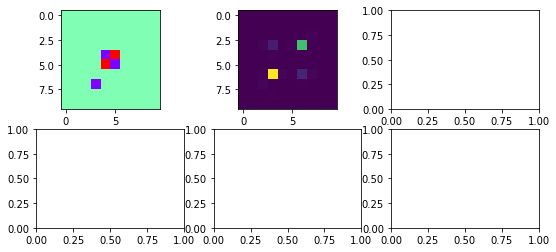

In [139]:
board = np.zeros((BOARD_SIZE, BOARD_SIZE, 1))

board[5][5] = 1
board[5][4] = -1
board[4][4] = 1
board[4][5] = -1
board[7][3] = 1

board *= -1

fig, ax = pyplot.subplots(1 + len(models), 3)

fig.set_size_inches(9, 1 + len(models) * 3)

for i, model in enumerate(models):
    ax[i][0].imshow(board.reshape(BOARD_SIZE, BOARD_SIZE), norm=Normalize(-1, 1), cmap='rainbow')
    
    prediction = model.predict(np.array([board]))
    
    ax[i][1].imshow(prediction.reshape(BOARD_SIZE, BOARD_SIZE))#, cmap='gray', norm=Normalize(0, 1))#, norm=Normalize(-1, 1), cmap='rainbow')
    
    #m_prediction = do_monte_carlo(board, 1, model)
    
    #ax[i][2].imshow(m_prediction.reshape(BOARD_SIZE, BOARD_SIZE), cmap='gray', norm=Normalize(0, 1))

    # break

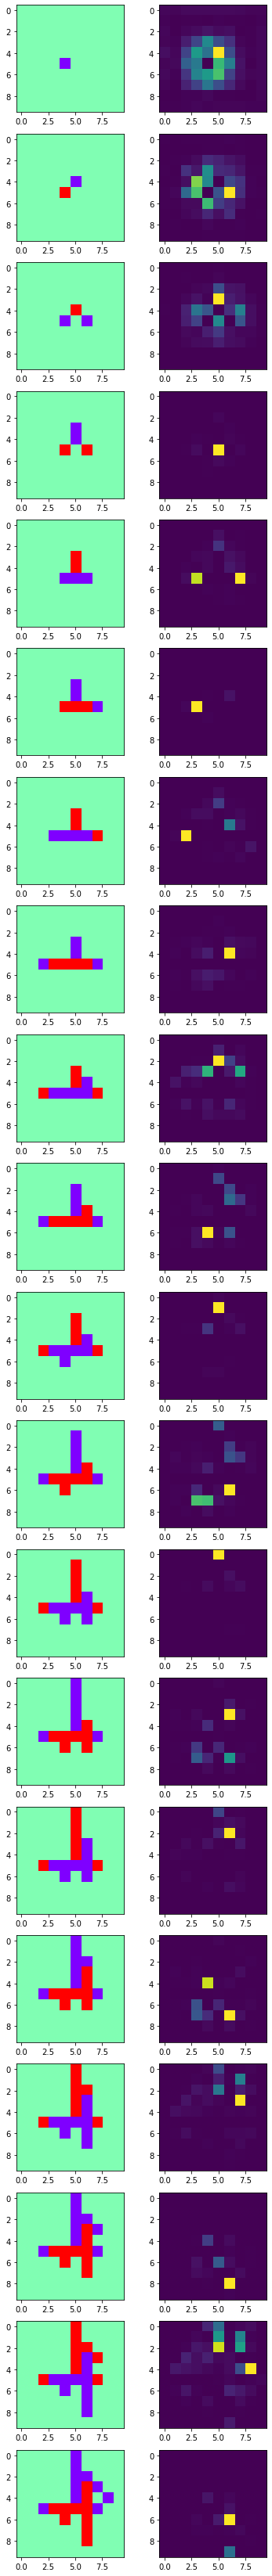

In [165]:
plays = 20

fig, ax = pyplot.subplots(plays, 2)
fig.set_size_inches(6, plays * 3)


board = np.zeros((BOARD_SIZE, BOARD_SIZE, 1))
board[5][4] = -1

for i in range(plays):
    
    ax[i][0].imshow(board.reshape(BOARD_SIZE, BOARD_SIZE), norm=Normalize(-1, 1), cmap='rainbow')
    
    prediction = model.predict(np.array([board]))[0]

    ax[i][1].imshow(prediction.reshape(BOARD_SIZE, BOARD_SIZE))
    
    x, y = get_best_play_pos(prediction)
    
    board[x][y] = 1
    
    board *= -1